# **CitiBike Ridership Analysis Before, During and After Lockdown**

Citibike is a bike sharing system serving New York and New Jersey Area.. I have chosen to do the analyisis for the month of July, August and September. I have chosen to do the analyisis for the month of June, July and August. The minimum and maximum tempertaure for these months is 64 and 84 degree, which make them to be favorable for bike riders.

<h1>What is going to be covered in this notebook?</h1>

This project analyses the ridership in NYC before, during and after pandemic in following areas: 
- How total number of rides has changed throughout
- Subscriber and Casual Customer Consumer Behavior
- Pick days before, during and after the pandemic
- Analysis of newly introduced e-bike
- Charing stations clusters for e-bikes
- Communities based on distance by using Louvain Communities



Data Source: https://s3.amazonaws.com/tripdata/index.html

In [1]:
import os
#This allows you to share while your Papersapce is running. If you don't have paperspace,Ignore this.
os.getenv("nqpkodlrws")

<h1>Download Your Data</h1>

In [2]:
import urllib.request

data_dir = './data/trips/'
if not os.path.exists(data_dir):
    print('creating weather directory')
    os.system('mkdir ./data')
    os.system('mkdir ./data/trips')

In [3]:
base_url = "https://s3.amazonaws.com/tripdata/"
months = ["202007-citibike-tripdata","202008-citibike-tripdata", "202009-citibike-tripdata", "JC-201907-citibike-tripdata", "JC-201908-citibike-tripdata","JC-201909-citibike-tripdata","JC-202107-citibike-tripdata","JC-202108-citibike-tripdata","JC-202109-citibike-tripdata",]
for month in months:
    fn = str(month) + '.csv.zip'
    if not os.path.isfile(data_dir+fn):
        print(f'Downloading {base_url+fn} to {data_dir+fn}')
        urllib.request.urlretrieve(base_url+fn, data_dir+fn)

In [4]:
!ls ./data/trips

202007-citibike-tripdata.csv	     JC-201909-citibike-tripdata.csv
202007-citibike-tripdata.csv.zip     JC-201909-citibike-tripdata.csv.zip
202008-citibike-tripdata.csv	     JC-202107-citibike-tripdata.csv
202008-citibike-tripdata.csv.zip     JC-202107-citibike-tripdata.csv.zip
202009-citibike-tripdata.csv	     JC-202108-citibike-tripdata.csv
202009-citibike-tripdata.csv.zip     JC-202108-citibike-tripdata.csv.zip
JC-201907-citibike-tripdata.csv      JC-202109-citibike-tripdata.csv
JC-201907-citibike-tripdata.csv.zip  JC-202109-citibike-tripdata.csv.zip
JC-201908-citibike-tripdata.csv      __MACOSX
JC-201908-citibike-tripdata.csv.zip


**Import the dependencies and libraries to be used in this project**

In [5]:
import pandas as pd
import numpy as np
import glob
import os

import cudf
import cuxfilter
import matplotlib.pyplot as plt
import seaborn as sns
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors
from cuxfilter.charts import bokeh, datashader, panel_widgets
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot
from pyproj import Proj, Transformer
from bokeh import palettes
from cuxfilter.layouts import double_feature

<h1>Read Your Data</h1>

In [6]:
import zipfile

extension = ".zip"
data_dir = './data/trips/'



for item in os.listdir(data_dir): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = data_dir + "/" + item # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(data_dir) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [7]:
all_files = glob.glob(data_dir + "*csv")
all_files.sort()
all_files

['./data/trips/202007-citibike-tripdata.csv',
 './data/trips/202008-citibike-tripdata.csv',
 './data/trips/202009-citibike-tripdata.csv',
 './data/trips/JC-201907-citibike-tripdata.csv',
 './data/trips/JC-201908-citibike-tripdata.csv',
 './data/trips/JC-201909-citibike-tripdata.csv',
 './data/trips/JC-202107-citibike-tripdata.csv',
 './data/trips/JC-202108-citibike-tripdata.csv',
 './data/trips/JC-202109-citibike-tripdata.csv']

In [8]:
li = []

for filename in all_files:
    df = cudf.read_csv(filename)
    li.append(df)
    
    


Concatenate the first three dataframes in an array to get the dataframe for 2020

In [9]:
df2020 = cudf.concat(li[0:3], ignore_index=True)
df2020

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,341,2020-07-01 00:00:01.3020,2020-07-01 00:05:42.5650,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1
1,321,2020-07-01 00:00:01.3620,2020-07-01 00:05:22.9490,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2
2,2710,2020-07-01 00:00:06.6290,2020-07-01 00:45:17.3410,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0
3,2685,2020-07-01 00:00:13.0220,2020-07-01 00:44:58.8640,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1
4,191,2020-07-01 00:00:13.4660,2020-07-01 00:03:24.6230,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6923542,1818,2020-09-30 23:59:48.8460,2020-10-01 00:30:07.7810,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,3836,Bushwick Ave & Linden St,40.691460,-73.921460,36220,Subscriber,1993,1
6923543,1553,2020-09-30 23:59:53.7240,2020-10-01 00:25:47.1760,390,Duffield St & Willoughby St,40.692216,-73.984284,3799,6 Ave & W 34 St,40.749640,-73.988050,31092,Subscriber,1995,1
6923544,626,2020-09-30 23:59:54.6670,2020-10-01 00:10:21.6050,3901,Stanhope St & Fairview Ave,40.709980,-73.911160,3083,Bushwick Ave & Powers St,40.712477,-73.941000,47224,Subscriber,1954,2
6923545,325,2020-09-30 23:59:56.2120,2020-10-01 00:05:21.3060,3148,E 84 St & 1 Ave,40.775655,-73.950686,3338,2 Ave & E 99 St,40.786259,-73.945526,16759,Subscriber,1995,2


Concatenate the middle three dataframes in an array to get the dataframe for 2019

In [10]:
df2019 = cudf.concat(li[3:6], ignore_index=True)
df2019

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1793,2019-07-01 00:00:36.6150,2019-07-01 00:30:30.5940,3186,Grove St PATH,40.719586,-74.043117,3198,Heights Elevator,40.748716,-74.040443,29595,Subscriber,1978,1
1,434,2019-07-01 00:02:54.6150,2019-07-01 00:10:09.0370,3206,Hilltop,40.731169,-74.057574,3280,Astor Place,40.719282,-74.071262,29647,Subscriber,1988,1
2,251,2019-07-01 00:03:27.5670,2019-07-01 00:07:38.6080,3186,Grove St PATH,40.719586,-74.043117,3205,JC Medical Center,40.716540,-74.049638,26271,Subscriber,1986,1
3,636,2019-07-01 00:03:56.1690,2019-07-01 00:14:32.4180,3206,Hilltop,40.731169,-74.057574,3281,Leonard Gordon Park,40.745910,-74.057271,26225,Customer,1996,2
4,623,2019-07-01 00:04:16.2060,2019-07-01 00:14:40.0500,3206,Hilltop,40.731169,-74.057574,3281,Leonard Gordon Park,40.745910,-74.057271,29230,Customer,1989,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141696,621,2019-09-30 23:11:40.0630,2019-09-30 23:22:01.8370,3194,McGinley Square,40.725340,-74.067622,3191,Union St,40.718211,-74.083639,26245,Subscriber,1962,1
141697,167,2019-09-30 23:19:02.9380,2019-09-30 23:21:50.8290,3211,Newark Ave,40.721525,-74.046305,3209,Brunswick St,40.724177,-74.050656,29525,Subscriber,1984,1
141698,94,2019-09-30 23:26:24.7470,2019-09-30 23:27:59.2310,3213,Van Vorst Park,40.718489,-74.047727,3483,Montgomery St,40.719420,-74.050990,26317,Subscriber,1958,1
141699,366,2019-09-30 23:49:00.4260,2019-09-30 23:55:06.9620,3638,Washington St,40.724294,-74.035483,3270,Jersey & 6th St,40.725289,-74.045572,29488,Subscriber,1976,1


Concatenate the last three dataframes in an array to get the dataframe for 2021

In [11]:
df2021 = cudf.concat(li[6:9], ignore_index=True)
df2021

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C9446233AFAB8896,classic_bike,2021-07-15 19:27:25,2021-07-15 19:27:35,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member
1,0C3D69370BE39992,electric_bike,2021-07-22 06:41:54,2021-07-22 06:42:03,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member
2,3B0390B706281176,classic_bike,2021-07-19 06:36:13,2021-07-19 06:38:18,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member
3,9AFBC07247ABE507,classic_bike,2021-07-08 06:33:45,2021-07-08 06:35:53,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member
4,ADB073F7FFC372D3,classic_bike,2021-07-21 07:33:49,2021-07-21 08:00:14,14 St Ferry - 14 St & Shipyard Ln,HB202,Columbus Dr at Exchange Pl,JC106,40.752961,-74.024353,40.716870,-74.032810,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
273707,69D4734AC92BC7D7,electric_bike,2021-09-09 21:23:45,2021-09-09 21:30:36,Van Vorst Park,JC035,Astor Place,JC077,40.718489,-74.047727,40.719282,-74.071262,member
273708,A54DD2451E15595B,classic_bike,2021-09-18 23:39:37,2021-09-18 23:52:36,Van Vorst Park,JC035,Astor Place,JC077,40.718489,-74.047727,40.719282,-74.071262,member
273709,D5D3F49E376ECC8B,classic_bike,2021-09-28 16:43:48,2021-09-28 16:57:56,Newark Ave,JC032,Astor Place,JC077,40.721525,-74.046305,40.719282,-74.071262,member
273710,335098A4D62D303F,classic_bike,2021-09-24 15:37:20,2021-09-24 15:46:09,Lincoln Park,JC053,Astor Place,JC077,40.724605,-74.078406,40.719282,-74.071262,casual


<h1>How total number of rides changed throughout?</h1>

**First, get the Total Trips throughout**

1. Get Total Trips for 2019 Summer.

In [12]:
summer_trips_2019=len(df2019.index)
summary_table_2019=cudf.DataFrame({"Total Trips in 2019 Summer":[summer_trips_2019]})
summary_table_2019

,Total Trips in 2019 Summer
0,141701


2. Get Total Trips for 2020 Summer.

In [13]:
summer_trips_2020=len(df2020.index)
summary_table_2020=cudf.DataFrame({"Total Trips in 2020 Summer":[summer_trips_2020]})
summary_table_2020

,Total Trips in 2020 Summer
0,6923547


3. Get Total Trips for 2021 Summer.

In [14]:
summer_trips_2021=len(df2021.index)
summary_table_2021=cudf.DataFrame({"Total Trips in 2021 Summer":[summer_trips_2021]})
summary_table_2021

,Total Trips in 2021 Summer
0,273712


4. Combine them into a single dataframe

In [15]:
TripsAll=cudf.DataFrame({"2019 Summer":[summer_trips_2019], "2020 Summer":[summer_trips_2020], "2021 Summer":[summer_trips_2021]})
TripsAll

,2019 Summer,2020 Summer,2021 Summer
0,141701,6923547,273712


In [16]:
#Transpose the dataframe
x=TripsAll.transpose().reset_index()
x

,index,0
0,2019 Summer,141701
1,2020 Summer,6923547
2,2021 Summer,273712


In [17]:
#Rename the 0 column to total
y=x.rename(columns={0:"Total"}, axis=2)
y

,index,Total
0,2019 Summer,141701
1,2020 Summer,6923547
2,2021 Summer,273712


**Getting the percentage change in ridership for 3 years**

In [18]:
#Create a column to get the difference for each year
y['difference']= y['Total'].diff()

#Create a column to get a percentage change for each year
y['percentage']=(y['Total'].pct_change())*100
z=y.fillna(0)
z

,index,Total,difference,percentage
0,2019 Summer,141701,0,0.000000
1,2020 Summer,6923547,6781846,4786.025504
2,2021 Summer,273712,-6649835,-96.046651


**Plot the table with Cuxfilter**

In [19]:
#Read the dataframe in cuxfilter
cux_df = cuxfilter.DataFrame.from_dataframe(z)
cux_df.data.head()

,index,Total,difference,percentage
0,2019 Summer,141701,0,0.000000
1,2020 Summer,6923547,6781846,4786.025504
2,2021 Summer,273712,-6649835,-96.046651


In [20]:
#Plot the chat
chart3 = cuxfilter.charts.bar(x='index', y='Total')
d = cux_df.dashboard([chart3])
chart3.view()

Card(sizing_mode='scale_width', title='index', width=400)
    [0] Bokeh(Figure)

# **Subscribers And Customers Behaviour**

**1.Get the count of each user type for every year**

i. Get the count for each usertype for each year

In [21]:
#Usertype count for 2019
xa=df2019.groupby(['usertype']).agg({'usertype': ['count']}).reset_index()
xa.columns=['usertype', 'count']
xa.head()

,usertype,count
0,Customer,21028
1,Subscriber,120673


In [22]:
#Usertype count 2020
xb=df2020.groupby(['usertype']).agg({'usertype': ['count']}).reset_index()
xb.columns=['usertype', 'count']
xb.head()

,usertype,count
0,Customer,1902977
1,Subscriber,5020570


In [23]:
#Usertype count 2021
xc=df2021.groupby(['member_casual']).agg({'member_casual': ['count']}).reset_index()
xc.columns=['usertype', 'count']
xc.head()

,usertype,count
0,casual,122849
1,member,150863


2. Concatenate to get a combined dataframe

In [24]:
xz=cudf.concat([xa, xb, xc], ignore_index=False)
xz['year']=(len(xa)*(0,) + len(xb)*(1,) + len(xc)*(2,))
xz.reset_index(inplace=True)
xz['year']=xz['year'].replace({0:2019, 1:2020, 2:2021})
xz['usertype']=xz['usertype'].replace({'casual':'Customer', 'member':'Subscriber'})
xz.rename(columns={'count':'Total'})
xz

,index,usertype,count,year
0,0,Customer,21028,2019
1,1,Subscriber,120673,2019
2,0,Customer,1902977,2020
3,1,Subscriber,5020570,2020
4,0,Customer,122849,2021
5,1,Subscriber,150863,2021


3. Change the Cudf in Pandas Dataframe and Plot

In [25]:
pxz=xz.to_pandas()

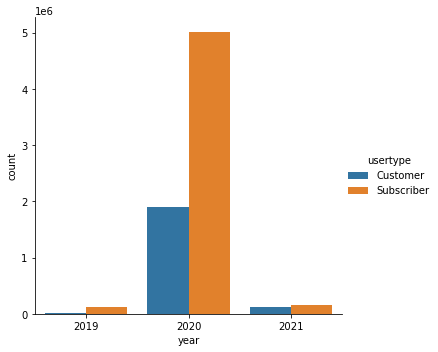

In [26]:
#Plot the graph
sns.factorplot(x='year', y='count', hue='usertype', kind='bar', data=pxz)

**2.Trip Durations comparison for each User Type**

2021 Dataframe do not have a column for trip duration like other dataframes for 2019 and 2020. We need first to create the column for trip durations for 2021 dataframe

In [27]:
#Read the 2021 dataframe
df2021.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C9446233AFAB8896,classic_bike,2021-07-15 19:27:25,2021-07-15 19:27:35,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member
1,0C3D69370BE39992,electric_bike,2021-07-22 06:41:54,2021-07-22 06:42:03,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member
2,3B0390B706281176,classic_bike,2021-07-19 06:36:13,2021-07-19 06:38:18,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member
3,9AFBC07247ABE507,classic_bike,2021-07-08 06:33:45,2021-07-08 06:35:53,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member
4,ADB073F7FFC372D3,classic_bike,2021-07-21 07:33:49,2021-07-21 08:00:14,14 St Ferry - 14 St & Shipyard Ln,HB202,Columbus Dr at Exchange Pl,JC106,40.752961,-74.024353,40.716870,-74.032810,casual


In [28]:
#Inspect the dataframe to get the data type info for each column
df2021.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 273712 entries, 0 to 273711
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   ride_id             273712 non-null  object
 1   rideable_type       273712 non-null  object
 2   started_at          273712 non-null  object
 3   ended_at            273712 non-null  object
 4   start_station_name  273712 non-null  object
 5   start_station_id    273712 non-null  object
 6   end_station_name    271976 non-null  object
 7   end_station_id      271976 non-null  object
 8   start_lat           273712 non-null  float64
 9   start_lng           273712 non-null  float64
 10  end_lat             272557 non-null  float64
 11  end_lng             272557 non-null  float64
 12  member_casual       273712 non-null  object
dtypes: float64(4), object(9)
memory usage: 49.6+ MB


We need to change Dtype for 'started_at' and 'ended_at' columns into datetime object, and then calculate the time in seconds and storing the values in a new column called Duration

In [29]:
df2021['started_at']=cudf.to_datetime(df2021['started_at'])
df2021['ended_at']=cudf.to_datetime(df2021['ended_at'])
df2021['Duration']= df2021['ended_at'] - df2021['started_at']
df2021['Duration']= df2021['Duration']/np.timedelta64(1,'s')

In [30]:
df2021.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Duration
0,C9446233AFAB8896,classic_bike,2021-07-15 19:27:25,2021-07-15 19:27:35,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member,10.0
1,0C3D69370BE39992,electric_bike,2021-07-22 06:41:54,2021-07-22 06:42:03,Journal Square,JC103,Journal Square,JC103,40.733670,-74.062500,40.733670,-74.062500,member,9.0
2,3B0390B706281176,classic_bike,2021-07-19 06:36:13,2021-07-19 06:38:18,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member,125.0
3,9AFBC07247ABE507,classic_bike,2021-07-08 06:33:45,2021-07-08 06:35:53,Brunswick & 6th,JC081,Jersey & 6th St,JC027,40.726012,-74.050389,40.725289,-74.045572,member,128.0
4,ADB073F7FFC372D3,classic_bike,2021-07-21 07:33:49,2021-07-21 08:00:14,14 St Ferry - 14 St & Shipyard Ln,HB202,Columbus Dr at Exchange Pl,JC106,40.752961,-74.024353,40.716870,-74.032810,casual,1585.0


Grouby Usertype and calculate median duration for each group

In [31]:
#Median duration for user type groups for year 2019
ya=df2019.groupby(['usertype']).agg({'tripduration': ['median']}).reset_index()
ya.columns=['usertype', 'median duration']
ya.head()

,usertype,median duration
0,Customer,840.0
1,Subscriber,336.0


In [32]:
#Median duration for user type groups for year 2020
yb=df2020.groupby(['usertype']).agg({'tripduration': ['median']}).reset_index()
yb.columns=['usertype', 'median duration']
yb.head()

,usertype,median duration
0,Customer,1192.0
1,Subscriber,739.0


In [33]:
#Median duration for user type groups for year 2021
yc=df2021.groupby(['member_casual']).agg({'Duration': ['median']}).reset_index()
yc.columns=['usertype', 'median duration']
yc.head()

,usertype,median duration
0,casual,686.0
1,member,426.0


Concatenate to get a single dataframe for durations

In [34]:
dftrip=cudf.concat([ya, yb, yc], ignore_index=False)
dftrip['year']=(len(ya)*(0,) + len(yb)*(1,) + len(yc)*(2,))
dftrip.reset_index(inplace=True)
dftrip['year']=dftrip['year'].replace({0:2019, 1:2020, 2:2021})
dftrip['usertype']=dftrip['usertype'].replace({'casual':'Customer', 'member':'Subscriber'})

dftrip

,index,usertype,median duration,year
0,0,Customer,840.0,2019
1,1,Subscriber,336.0,2019
2,0,Customer,1192.0,2020
3,1,Subscriber,739.0,2020
4,0,Customer,686.0,2021
5,1,Subscriber,426.0,2021


Plotting

In [35]:
#Change the dataframe into pandas
pdftrip=dftrip.to_pandas()

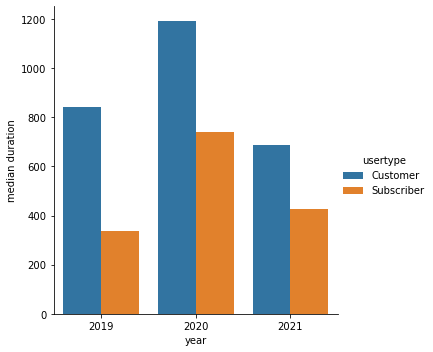

In [36]:
#Plotting
sns.factorplot(x='year', y='median duration', hue='usertype', kind='bar', data=pdftrip)

<h1>Pick days before, during and after the pandemic</h1>

In [37]:
df2019['starttime']=cudf.to_datetime(df2019['starttime'])
df2019['stoptime']=cudf.to_datetime(df2019['stoptime'])
df2019['dow']=df2019['starttime'].dt.dayofweek
df2019.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow
0,1793,2019-07-01 00:00:36.615,2019-07-01 00:30:30.594,3186,Grove St PATH,40.719586,-74.043117,3198,Heights Elevator,40.748716,-74.040443,29595,Subscriber,1978,1,0
1,434,2019-07-01 00:02:54.615,2019-07-01 00:10:09.037,3206,Hilltop,40.731169,-74.057574,3280,Astor Place,40.719282,-74.071262,29647,Subscriber,1988,1,0
2,251,2019-07-01 00:03:27.567,2019-07-01 00:07:38.608,3186,Grove St PATH,40.719586,-74.043117,3205,JC Medical Center,40.716540,-74.049638,26271,Subscriber,1986,1,0
3,636,2019-07-01 00:03:56.169,2019-07-01 00:14:32.418,3206,Hilltop,40.731169,-74.057574,3281,Leonard Gordon Park,40.745910,-74.057271,26225,Customer,1996,2,0
4,623,2019-07-01 00:04:16.206,2019-07-01 00:14:40.050,3206,Hilltop,40.731169,-74.057574,3281,Leonard Gordon Park,40.745910,-74.057271,29230,Customer,1989,1,0


In [38]:
cux_df2019 = cuxfilter.DataFrame.from_dataframe(df2019)

label_map = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
   
    
}
chart6 = cuxfilter.charts.line('dow', x_label_map=label_map, aggregate_fn='count', title='Ridership before pandemic')
d = cux_df2019.dashboard([chart6])
chart6.view()

Card(sizing_mode='scale_width', title='Ridership before p..., width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=6, sizing_mode='scale_width', step=1, value=(0, 6), value_end=6, width=400)

In [39]:
df2020['starttime']=cudf.to_datetime(df2020['starttime'])
df2020['stoptime']=cudf.to_datetime(df2020['stoptime'])
df2020['dow']=df2020['starttime'].dt.dayofweek

In [40]:
cux_df2020 = cuxfilter.DataFrame.from_dataframe(df2020)
chart7 = cuxfilter.charts.line('dow', x_label_map=label_map, aggregate_fn='count', title="Ridership During Pandemic")
d = cux_df2020.dashboard([chart7])
chart7.view()

Card(sizing_mode='scale_width', title='Ridership During P..., width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=6, sizing_mode='scale_width', step=1, value=(0, 6), value_end=6, width=400)

In [41]:
df2021['dow']=df2021['started_at'].dt.dayofweek
cux_df2021 = cuxfilter.DataFrame.from_dataframe(df2021)
chart8 = cuxfilter.charts.line('dow', x_label_map=label_map, aggregate_fn='count', title='Ridership After Pandemic')
d = cux_df2021.dashboard([chart8])
chart8.view()

Card(sizing_mode='scale_width', title='Ridership After P..., width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=6, sizing_mode='scale_width', step=1, value=(0, 6), value_end=6, width=400)

# **Electronic Bikes**

**How many Customers and Subscribers used electrical bikes and other types of bikes?**

In [42]:
types=df2021.groupby(['rideable_type','member_casual']).agg({'member_casual': ['count']}).reset_index()

types.columns=['Bike Type', 'usertype', 'count']
types.head()

,Bike Type,usertype,count
0,classic_bike,casual,73950
1,classic_bike,member,113685
2,docked_bike,casual,4489
3,electric_bike,casual,44410
4,electric_bike,member,37178


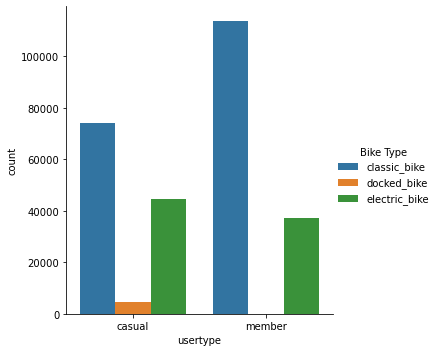

In [43]:
ptypes=types.to_pandas()
sns.factorplot(x='usertype', y='count', hue='Bike Type', kind='bar', data=ptypes)

**What were the trip Durations fro each type of bike per User categories?**

In [44]:
typesd=df2021.groupby(['rideable_type','member_casual']).agg({'Duration': ['sum']}).reset_index()

typesd.columns=['Bike Type', 'usertype', 'Duration Sum']
typesd.head()

,Bike Type,usertype,Duration Sum
0,electric_bike,casual,58227723.0
1,classic_bike,member,89078602.0
2,electric_bike,member,23988039.0
3,docked_bike,casual,53303422.0
4,classic_bike,casual,120475324.0


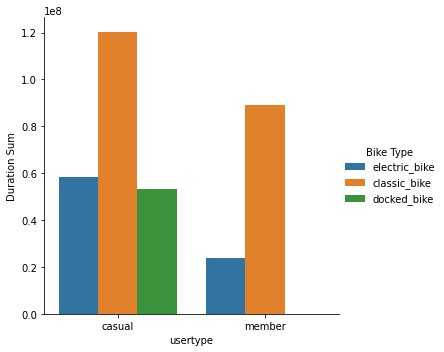

In [45]:
ptypes=typesd.to_pandas()
sns.factorplot(x='usertype', y='Duration Sum', hue='Bike Type', kind='bar', data=ptypes)

# **Knn Means to Make Clusters for E-bikes Stations**

In [46]:
from cuml import KMeans
from cuml.cluster import KMeans
import numpy as np
import pandas as pd
import cuspatial

In [47]:
df2020.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow
0,341,2020-07-01 00:00:01.302,2020-07-01 00:05:42.565,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1,2
1,321,2020-07-01 00:00:01.362,2020-07-01 00:05:22.949,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2,2
2,2710,2020-07-01 00:00:06.629,2020-07-01 00:45:17.341,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0,2
3,2685,2020-07-01 00:00:13.022,2020-07-01 00:44:58.864,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1,2
4,191,2020-07-01 00:00:13.466,2020-07-01 00:03:24.623,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1,2


**Use Kmeans to predict clusters based on latitude and longitudes**

In [48]:
coord = df2020[["start station latitude", "start station longitude"]].values
kmeans = KMeans(n_clusters=40).fit(coord)
df2020['pickup_cluster'] = kmeans.predict(df2020[['start station latitude', 'start station longitude']])
df2020.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow,pickup_cluster
0,341,2020-07-01 00:00:01.302,2020-07-01 00:05:42.565,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1,2,3
1,321,2020-07-01 00:00:01.362,2020-07-01 00:05:22.949,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2,2,3
2,2710,2020-07-01 00:00:06.629,2020-07-01 00:45:17.341,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0,2,6
3,2685,2020-07-01 00:00:13.022,2020-07-01 00:44:58.864,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1,2,6
4,191,2020-07-01 00:00:13.466,2020-07-01 00:03:24.623,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1,2,0


Change latitude to longitude to mercator coorditanes and use bokeh map for plotting

In [49]:
def makeXfilter(x, y):
    temp= cudf.DataFrame()
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    temp['x'], temp['y'] = transform_4326_to_3857.transform(
                                                x.to_array(), y.to_array()
                                            )
    print(temp.head())
    return temp.x, temp.y

In [50]:
df2020["start_latitudeM"], df2020["start_longitudeM"] = makeXfilter(df2020["start station latitude"], df2020["start station longitude"])

df2020.head()

              x             y
0 -8.236304e+06  4.973386e+06
1 -8.236304e+06  4.973386e+06
2 -8.239114e+06  4.970769e+06
3 -8.239114e+06  4.970769e+06
4 -8.231641e+06  4.975242e+06


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow,pickup_cluster,start_latitudeM,start_longitudeM
0,341,2020-07-01 00:00:01.302,2020-07-01 00:05:42.565,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1,2,3,-8.236304e+06,4.973386e+06
1,321,2020-07-01 00:00:01.362,2020-07-01 00:05:22.949,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2,2,3,-8.236304e+06,4.973386e+06
2,2710,2020-07-01 00:00:06.629,2020-07-01 00:45:17.341,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0,2,6,-8.239114e+06,4.970769e+06
3,2685,2020-07-01 00:00:13.022,2020-07-01 00:44:58.864,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1,2,6,-8.239114e+06,4.970769e+06
4,191,2020-07-01 00:00:13.466,2020-07-01 00:03:24.623,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1,2,0,-8.231641e+06,4.975242e+06


In [51]:
# Change the dataframe to cux df
cux_df2020 = cuxfilter.DataFrame.from_dataframe(df2020)
cux_df2020.data.tail()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow,pickup_cluster,start_latitudeM,start_longitudeM
6923542,1818,2020-09-30 23:59:48.846,2020-10-01 00:30:07.781,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,3836,Bushwick Ave & Linden St,40.691460,-73.921460,36220,Subscriber,1993,1,2,14,-8.237936e+06,4.973923e+06
6923543,1553,2020-09-30 23:59:53.724,2020-10-01 00:25:47.176,390,Duffield St & Willoughby St,40.692216,-73.984284,3799,6 Ave & W 34 St,40.749640,-73.988050,31092,Subscriber,1995,1,2,22,-8.235893e+06,4.967049e+06
6923544,626,2020-09-30 23:59:54.667,2020-10-01 00:10:21.605,3901,Stanhope St & Fairview Ave,40.709980,-73.911160,3083,Bushwick Ave & Powers St,40.712477,-73.941000,47224,Subscriber,1954,2,2,30,-8.227753e+06,4.969657e+06
6923545,325,2020-09-30 23:59:56.212,2020-10-01 00:05:21.306,3148,E 84 St & 1 Ave,40.775655,-73.950686,3338,2 Ave & E 99 St,40.786259,-73.945526,16759,Subscriber,1995,2,2,5,-8.232153e+06,4.979307e+06
6923546,128,2020-09-30 23:59:57.835,2020-10-01 00:02:06.092,439,E 4 St & 2 Ave,40.726281,-73.989780,312,Allen St & Stanton St,40.722055,-73.989111,47718,Subscriber,1996,2,2,27,-8.236505e+06,4.972052e+06


In [52]:
chart1 = cuxfilter.charts.scatter(x='start_latitudeM', y='start_longitudeM', aggregate_col='pickup_cluster', title='Clusters for charging stations', aggregate_fn='mean',
                                color_palette=palettes.turbo(40), tile_provider='CartoLight', x_range=(-8267428.97, -8207328.23), y_range=(4935861.67, 5000548.55),
                                pixel_shade_type='linear')
d = cux_df2020.dashboard([chart1])
chart1.view()

Card(sizing_mode='scale_width', title='Clusters for c..., width=800)
    [0] HoloViews(DynamicMap, height=400, sizing_mode='stretch_both')

# **Clustering Communities Based on Distance with Cugraph**

In [53]:
import cugraph
import cuspatial

In [54]:
def haversine_dist(cdf):
    cdf['h_distance']=cuspatial.haversine_distance(
    cdf['start station latitude'],
    cdf['start station longitude'],
    cdf['end station latitude'],
    cdf['end station longitude']
    )
    cdf['h_distance']=cdf['h_distance'].astype('float32')
    return cdf
df2020=haversine_dist(df2020)
df2020.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dow,pickup_cluster,start_latitudeM,start_longitudeM,h_distance
0,341,2020-07-01 00:00:01.302,2020-07-01 00:05:42.565,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1,2,3,-8.236304e+06,4.973386e+06,0.827523
1,321,2020-07-01 00:00:01.362,2020-07-01 00:05:22.949,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2,2,3,-8.236304e+06,4.973386e+06,0.827523
2,2710,2020-07-01 00:00:06.629,2020-07-01 00:45:17.341,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0,2,6,-8.239114e+06,4.970769e+06,1.063731
3,2685,2020-07-01 00:00:13.022,2020-07-01 00:44:58.864,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1,2,6,-8.239114e+06,4.970769e+06,1.063731
4,191,2020-07-01 00:00:13.466,2020-07-01 00:03:24.623,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1,2,0,-8.231641e+06,4.975242e+06,0.669928


In [55]:
G = cugraph.Graph()
G.from_cudf_edgelist(df2020, source='start station id', destination='end station id', edge_attr='h_distance', renumber=True)

In [56]:
df2020, mod = cugraph.louvain(G) 

In [57]:
df2020_l, mod_l = cugraph.leiden(G) 

In [58]:
print('Louvain Modularity was {}'.format(mod))
print()

Louvain Modularity was 0.17116093635559082



In [59]:
print('Leiden Modularity was {}'.format(mod_l))
print()

Leiden Modularity was 0.15811774134635925



In [60]:
part_ids = df2020["partition"].unique()

In [61]:
print("Louvain found " + str(len(part_ids)) + " partitions")

Louvain found 2 partitions


In [62]:
for p in range(len(part_ids)):
    part = []
    for i in range(len(df2020)):
        if (df2020['partition'].iloc[i] == p):
            part.append(df2020['vertex'].iloc[i] )
    print("Partition " + str(p) + ":")
    print(part)

Partition 0:
[3598, 3588, 3390, 3528, 522, 3226, 3293, 3814, 3157, 276, 408, 3131, 3603, 3934, 3959, 4123, 3946, 3359, 3997, 3654, 3649, 3515, 4017, 3566, 3517, 4070, 4020, 3513, 3745, 3554, 3623, 3144, 4133, 4140, 3954, 4156, 4091, 4201, 4126, 4159, 4152, 4161, 4137, 4169, 4150, 4129, 4195, 267, 3898, 228, 3514, 3630, 3362, 3463, 3570, 3926, 3530, 3589, 3500, 3555, 3387, 3541, 3572, 3600, 3999, 3527, 3424, 3506, 3130, 3327, 3778, 3499, 3920, 3531, 4023, 3542, 3516, 3343, 3610, 3510, 4038, 3540, 3524, 3520, 3563, 3565, 3561, 4012, 3521, 3171, 4045, 252, 3534, 3472, 3283, 3160, 3145, 3289, 3345, 4121, 3126, 3150, 3235, 4124, 3284, 4120, 3425, 3689, 3285, 534, 3535, 3936, 143, 3498, 3575, 4110, 3309, 3914, 434, 257, 4075, 3314, 454, 328, 3518, 3305, 3367, 3161, 167, 3263, 327, 486, 238, 466, 465, 3170, 346, 503, 442, 151, 380, 3137, 285, 468, 509, 462, 2006, 284, 3812, 3799, 2008, 478, 445, 505, 3376, 500, 3132, 440, 3154, 3172, 484, 3497, 3533, 4037, 4036, 3726, 4043, 3122, 4014, 4000, 

In [63]:
part_ids_l = df2020_l["partition"].unique()
print("Leiden found " + str(len(part_ids_l)) + " partitions")

Leiden found 2 partitions


In [64]:
for p in range(len(part_ids_l)):
    part = []
    for i in range(len(df2020)):
        if (df2020['partition'].iloc[i] == p):
            part.append(df2020['vertex'].iloc[i] )
    print("Partition " + str(p) + ":")
    print(part)

Partition 0:
[3598, 3588, 3390, 3528, 522, 3226, 3293, 3814, 3157, 276, 408, 3131, 3603, 3934, 3959, 4123, 3946, 3359, 3997, 3654, 3649, 3515, 4017, 3566, 3517, 4070, 4020, 3513, 3745, 3554, 3623, 3144, 4133, 4140, 3954, 4156, 4091, 4201, 4126, 4159, 4152, 4161, 4137, 4169, 4150, 4129, 4195, 267, 3898, 228, 3514, 3630, 3362, 3463, 3570, 3926, 3530, 3589, 3500, 3555, 3387, 3541, 3572, 3600, 3999, 3527, 3424, 3506, 3130, 3327, 3778, 3499, 3920, 3531, 4023, 3542, 3516, 3343, 3610, 3510, 4038, 3540, 3524, 3520, 3563, 3565, 3561, 4012, 3521, 3171, 4045, 252, 3534, 3472, 3283, 3160, 3145, 3289, 3345, 4121, 3126, 3150, 3235, 4124, 3284, 4120, 3425, 3689, 3285, 534, 3535, 3936, 143, 3498, 3575, 4110, 3309, 3914, 434, 257, 4075, 3314, 454, 328, 3518, 3305, 3367, 3161, 167, 3263, 327, 486, 238, 466, 465, 3170, 346, 503, 442, 151, 380, 3137, 285, 468, 509, 462, 2006, 284, 3812, 3799, 2008, 478, 445, 505, 3376, 500, 3132, 440, 3154, 3172, 484, 3497, 3533, 4037, 4036, 3726, 4043, 3122, 4014, 4000, 